# Lab 3: Contextual Bandit-Based News Article Recommendation System

In [1099]:
# Import libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

np.random.seed(82)

# Display settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

## Task 5.1: Data Pre-processing

In [1100]:
# Load the training data
df = pd.read_csv('/kaggle/input/datasets/harkiratsingh2424/train-users-csv/train_users.csv')  # Update path as needed
print(f"Dataset shape: {df.shape}")
print(f"Number of users: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")
df.head()

Dataset shape: (2000, 33)
Number of users: 2000
Number of features: 33


,user_id,age,income,clicks,purchase_amount,session_duration,content_variety,engagement_score,num_transactions,avg_monthly_spend,avg_cart_value,browsing_depth,revisit_rate,scroll_activity,time_on_site,interaction_count,preferred_price_range,discount_usage_rate,wishlist_size,product_views,repeat_purchase_gap (days),churn_risk_score,loyalty_index,screen_brightness,battery_percentage,cart_abandonment_count,browser_version,background_app_count,session_inactivity_duration,network_jitter,region_code,subscriber,label
0,U7392,NaN,23053,10,500.00,17.34,0.36661,37.29781,3,187.44,119.61,13,0.255,59,19.0,18,335.16,0.341,3,41,133.0,0.579825,15.0,4.0,2.0,8,3.17.97,10,22.75,8.0,Z999,False,user_3
1,U2702,56.0,20239,11,913.33,22.22,0.61370,59.36342,5,145.15,189.06,14,0.540,65,31.0,8,930.00,0.374,4,70,92.0,0.432731,33.0,4.5,63.0,5,1.57.10,8,1.75,4.0,U428,True,user_2
2,U2461,NaN,13907,9,1252.62,41.57,0.80368,76.78706,7,282.03,161.75,23,0.395,139,44.0,20,1216.41,0.274,5,45,67.0,0.308166,24.0,1.3,22.0,2,2.16.94,12,29.33,18.0,Z999,True,user_3
3,U7475,NaN,26615,12,500.00,30.17,0.26499,30.19441,10,195.35,23.91,15,0.204,99,35.0,16,398.62,0.252,6,62,149.0,0.708171,11.0,4.2,77.0,9,9.90.20,4,21.61,22.0,X123,False,user_3
4,U6040,32.0,27958,13,500.00,65.27,0.36385,37.12153,5,439.68,57.68,39,0.313,180,62.0,30,462.73,0.267,0,67,117.0,0.595416,19.0,4.6,30.0,9,1.99.38,7,7.58,52.0,S043,False,user_1


In [1101]:
# Check for missing values
print("Missing Values Summary:")
missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': df.isnull().sum().values,
    'Missing Percentage': (df.isnull().sum().values / len(df) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print(missing_summary)

Missing Values Summary:
  Column  Missing Count  Missing Percentage
1    age            698                34.9


In [1102]:
# Check label distribution
print("\nLabel Distribution:")
label_counts = df['label'].value_counts()
print(label_counts)
print(f"\nPercentage distribution:")
print((label_counts / len(df) * 100).round(2))


Label Distribution:
label
user_2    712
user_1    707
user_3    581
Name: count, dtype: int64

Percentage distribution:
label
user_2    35.60
user_1    35.35
user_3    29.05
Name: count, dtype: float64


In [1103]:
# Identify column types
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

# Remove target and ID from feature lists
if 'label' in numerical_cols:
    numerical_cols.remove('label')
if 'label' in categorical_cols:
    categorical_cols.remove('label')
if 'user_id' in categorical_cols:
    categorical_cols.remove('user_id')

print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")

Numerical columns (28): ['age', 'income', 'clicks', 'purchase_amount', 'session_duration', 'content_variety', 'engagement_score', 'num_transactions', 'avg_monthly_spend', 'avg_cart_value', 'browsing_depth', 'revisit_rate', 'scroll_activity', 'time_on_site', 'interaction_count', 'preferred_price_range', 'discount_usage_rate', 'wishlist_size', 'product_views', 'repeat_purchase_gap (days)', 'churn_risk_score', 'loyalty_index', 'screen_brightness', 'battery_percentage', 'cart_abandonment_count', 'background_app_count', 'session_inactivity_duration', 'network_jitter']

Categorical columns (3): ['browser_version', 'region_code', 'subscriber']


In [1104]:
# Create a copy for preprocessing
df_processed = df.copy()

# Remove user_id column as it's not a feature
df_processed = df_processed.drop('user_id', axis=1)

print("Dropped 'user_id' column")
print(f"New shape: {df_processed.shape}")

Dropped 'user_id' column
New shape: (2000, 32)


In [1105]:
# Handle missing values in numerical columns
# Using median imputation for numerical features
numerical_imputer = SimpleImputer(strategy='median')

# Get numerical columns (excluding label)
num_cols_to_impute = [col for col in numerical_cols if col in df_processed.columns]

if num_cols_to_impute:
    df_processed[num_cols_to_impute] = numerical_imputer.fit_transform(df_processed[num_cols_to_impute])
    print(f"Imputed missing values in {len(num_cols_to_impute)} numerical columns using median strategy")

# Verify no missing values remain
print(f"\nRemaining missing values: {df_processed.isnull().sum().sum()}")

Imputed missing values in 28 numerical columns using median strategy

Remaining missing values: 0


In [1106]:
# Encode categorical features
label_encoders = {}

# Encode categorical columns (excluding the target 'label')
cat_cols_to_encode = [col for col in categorical_cols if col in df_processed.columns and col != 'label']

for col in cat_cols_to_encode:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded column: {col} ({df_processed[col].nunique()} unique values)")

print(f"\nTotal categorical columns encoded: {len(cat_cols_to_encode)}")

Encoded column: browser_version (1973 unique values)
Encoded column: region_code (1284 unique values)
Encoded column: subscriber (2 unique values)

Total categorical columns encoded: 3


In [1107]:
# Encode target variable (label)
target_encoder = LabelEncoder()
df_processed['label_encoded'] = target_encoder.fit_transform(df_processed['label'])

print("Target variable encoding:")
for i, class_name in enumerate(target_encoder.classes_):
    print(f"  {class_name} -> {i}")

Target variable encoding:
  user_1 -> 0
  user_2 -> 1
  user_3 -> 2


In [1108]:
# Separate features and target
X = df_processed.drop(['label', 'label_encoded'], axis=1)
y = df_processed['label_encoded']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns ({X.shape[1]}): {list(X.columns)}")

Features shape: (2000, 31)
Target shape: (2000,)

Feature columns (31): ['age', 'income', 'clicks', 'purchase_amount', 'session_duration', 'content_variety', 'engagement_score', 'num_transactions', 'avg_monthly_spend', 'avg_cart_value', 'browsing_depth', 'revisit_rate', 'scroll_activity', 'time_on_site', 'interaction_count', 'preferred_price_range', 'discount_usage_rate', 'wishlist_size', 'product_views', 'repeat_purchase_gap (days)', 'churn_risk_score', 'loyalty_index', 'screen_brightness', 'battery_percentage', 'cart_abandonment_count', 'browser_version', 'background_app_count', 'session_inactivity_duration', 'network_jitter', 'region_code', 'subscriber']


In [1109]:
# Display summary statistics
print("Summary Statistics of Features:")
X.describe()

Summary Statistics of Features:


,age,income,clicks,purchase_amount,session_duration,content_variety,engagement_score,num_transactions,avg_monthly_spend,avg_cart_value,browsing_depth,revisit_rate,scroll_activity,time_on_site,interaction_count,preferred_price_range,discount_usage_rate,wishlist_size,product_views,repeat_purchase_gap (days),churn_risk_score,loyalty_index,screen_brightness,battery_percentage,cart_abandonment_count,browser_version,background_app_count,session_inactivity_duration,network_jitter,region_code,subscriber
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,39.148000,21564.393500,10.526000,854.920700,32.641035,0.491309,49.325532,6.019000,359.416645,172.206590,19.565500,0.351361,98.116500,32.936000,14.486000,855.162015,0.300158,3.003500,52.151000,105.842000,0.506943,21.145000,3.057850,51.219000,5.05300,988.705000,9.456500,15.091855,24.514500,824.706000,0.278000
std,9.203176,6740.282694,3.299207,833.770472,22.769625,0.244320,24.584840,2.561429,413.886399,189.172863,12.778198,0.141125,69.124381,23.858091,8.566884,841.260803,0.121174,2.680313,19.834059,37.053482,0.246216,9.541934,1.102046,27.704671,2.28797,569.503186,3.457034,8.547876,18.501836,395.264335,0.448125
min,18.000000,10000.000000,1.000000,500.000000,0.000000,0.005040,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,109.320000,0.033000,0.000000,0.000000,17.000000,0.000000,0.000000,1.200000,2.000000,0.00000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,16742.500000,8.000000,500.000000,10.987500,0.289365,31.912582,4.000000,150.147500,67.840000,8.000000,0.251000,35.000000,12.000000,8.000000,460.177500,0.221750,1.000000,39.000000,83.000000,0.351813,15.000000,2.100000,28.000000,3.00000,496.750000,6.000000,7.657500,10.000000,487.750000,0.000000
50%,39.000000,21107.500000,10.000000,500.000000,33.475000,0.493505,49.566750,6.000000,231.370000,106.145000,20.000000,0.348000,98.000000,31.000000,14.000000,539.750000,0.279000,3.000000,52.000000,106.000000,0.507508,20.000000,3.100000,52.000000,5.00000,989.500000,9.000000,15.420000,21.000000,974.500000,0.000000
75%,42.000000,25892.500000,13.000000,596.295000,48.732500,0.661632,64.603265,8.000000,393.437500,184.415000,29.000000,0.440000,146.000000,51.000000,21.000000,691.692500,0.355000,5.000000,65.000000,133.000000,0.679260,26.000000,4.000000,74.000000,6.00000,1481.250000,12.000000,22.295000,35.000000,1151.000000,1.000000
max,70.000000,51776.000000,25.000000,4873.670000,89.960000,0.993540,100.000000,19.000000,4555.030000,1000.000000,50.000000,0.812000,280.000000,99.000000,42.000000,4927.900000,0.789000,15.000000,116.000000,180.000000,1.000000,77.000000,5.000000,100.000000,14.00000,1972.000000,15.000000,29.980000,95.000000,1283.000000,1.000000


## Task 5.2: User Classification

In [1110]:
# Split the data: 80% training, 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class distribution
)

print(f"\nTraining set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")

# Verify stratification
print("\nClass distribution in training set:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nClass distribution in validation set:")
print(pd.Series(y_val).value_counts().sort_index())


Training set size: 1600 samples (80.0%)
Validation set size: 400 samples (20.0%)

Class distribution in training set:
label_encoded
0    565
1    570
2    465
Name: count, dtype: int64

Class distribution in validation set:
label_encoded
0    142
1    142
2    116
Name: count, dtype: int64


In [1111]:
# Scale features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Validation set shape: {X_val_scaled.shape}")

Training set shape: (1600, 31)
Validation set shape: (400, 31)


In [1112]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        random_state=42,
        multi_class='multinomial',
        solver='lbfgs'
    )
}

print("Models initialized:")
for name in models.keys():
    print(f"  - {name}")

Models initialized:
  - Random Forest
  - Decision Tree
  - Logistic Regression


In [1113]:
# Train and evaluate all models
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # Use scaled data for Logistic Regression, original for tree-based models
    if name == 'Logistic Regression':
        X_train_use = X_train_scaled
        X_val_use = X_val_scaled
    else:
        X_train_use = X_train
        X_val_use = X_val
    
    # Train the model
    model.fit(X_train_use, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train_use)
    y_val_pred = model.predict(X_val_use)
    
    # Calculate accuracies
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    
    # Store results
    results[name] = {
        'model': model,
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'predictions': y_val_pred
    }
    
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Difference: {abs(train_acc - val_acc):.4f}\n")

Training Random Forest...
Training Accuracy: 0.9744
Validation Accuracy: 0.9000
Difference: 0.0744

Training Decision Tree...
Training Accuracy: 0.9225
Validation Accuracy: 0.8650
Difference: 0.0575

Training Logistic Regression...
Training Accuracy: 0.8381
Validation Accuracy: 0.8200
Difference: 0.0181



In [1114]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Training Accuracy': [results[m]['train_accuracy'] for m in results.keys()],
    'Validation Accuracy': [results[m]['val_accuracy'] for m in results.keys()],
    'Overfitting': [abs(results[m]['train_accuracy'] - results[m]['val_accuracy']) for m in results.keys()]
})

comparison_df = comparison_df.sort_values('Validation Accuracy', ascending=False)
print("\nModel Comparison:")
print(comparison_df.to_string(index=False))


Model Comparison:
              Model  Training Accuracy  Validation Accuracy  Overfitting
      Random Forest           0.974375                0.900     0.074375
      Decision Tree           0.922500                0.865     0.057500
Logistic Regression           0.838125                0.820     0.018125


In [1115]:
# Select best model based on validation accuracy
best_model_name = max(results.items(), key=lambda x: x[1]['val_accuracy'])[0]
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

print(f"Best Model: {best_model_name}")
print(f"Validation Accuracy: {results[best_model_name]['val_accuracy']:.4f}")

Best Model: Random Forest
Validation Accuracy: 0.9000


In [1116]:
# Classification Report
print(f"CLASSIFICATION REPORT - {best_model_name}")
print(classification_report(y_val, best_predictions, 
                          target_names=target_encoder.classes_,
                          digits=4))

CLASSIFICATION REPORT - Random Forest
              precision    recall  f1-score   support

      user_1     0.8971    0.8592    0.8777       142
      user_2     0.9766    0.8803    0.9259       142
      user_3     0.8309    0.9741    0.8968       116

    accuracy                         0.9000       400
   macro avg     0.9015    0.9045    0.9001       400
weighted avg     0.9061    0.9000    0.9004       400



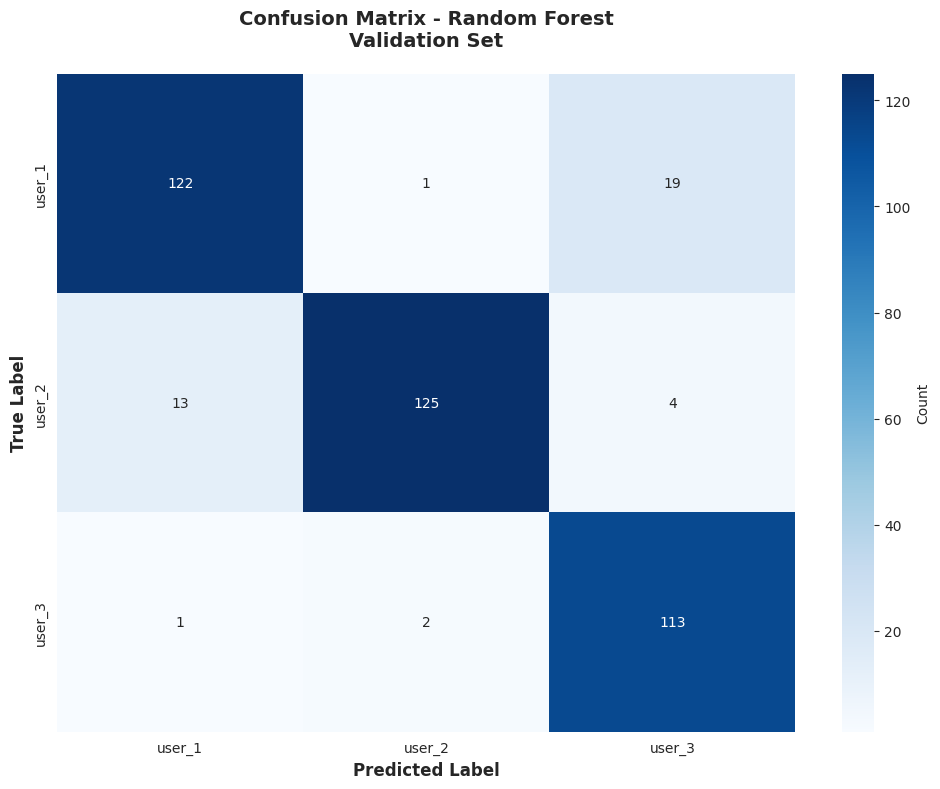


Per-Class Accuracy:
  user_1: 0.8592
  user_2: 0.8803
  user_3: 0.9741


In [1117]:
# Confusion Matrix
cm = confusion_matrix(y_val, best_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}\nValidation Set', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate per-class accuracy from confusion matrix
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(target_encoder.classes_):
    class_acc = cm[i, i] / cm[i, :].sum()
    print(f"  {class_name}: {class_acc:.4f}")

## Task 5.3: Contextual Bandit Algorithms

In [1118]:
# Define colors and context labels for consistent visualization across all plots
# These will be used in all reward vs. time plots

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # Red, Teal, Blue for User1, User2, User3
contexts = ['User1', 'User2', 'User3']

print("✅ Visualization settings configured")
print(f"Colors: {colors}")
print(f"Contexts: {contexts}")

✅ Visualization settings configured
Colors: ['#FF6B6B', '#4ECDC4', '#45B7D1']
Contexts: ['User1', 'User2', 'User3']


In [1119]:
# Install and import sampler
!pip install rlcmab_sampler

In [1120]:
from rlcmab_sampler import sampler
ROLL_NUMBER = 82 
reward_sampler = sampler(ROLL_NUMBER)

print(f"Initialized sampler with Roll Number: {ROLL_NUMBER}")

Initialized sampler with Roll Number: 82


### 5.3.2: Epsilon-Greedy Algorithm

In [1121]:
# Train Epsilon-Greedy with different epsilon values
EPSILON_VALUES = [0.01, 0.1, 0.3]
T = 10000  # Time horizon PER CONTEXT

epsilon_greedy_agents = {}
epsilon_greedy_results = {}

print("Training Epsilon-Greedy Agents...\n")
print("Training approach: 10,000 steps PER CONTEXT (30,000 total)\n")

# Reset sampler for each run
reward_sampler = sampler(ROLL_NUMBER)

for eps in EPSILON_VALUES:
    print(f"\nTraining with ε = {eps}")
    agent = EpsilonGreedy(epsilon=eps)
    
    # Training loop
    all_rewards = []
    context_rewards = {0: [], 1: [], 2: []}
    cumulative_reward_over_time = []
    total_reward = 0
    
    # Train each context separately with its own 10,000 step budget
    for context in range(3):
        print(f"  Training Context {context} (User{context+1})...")
        
        for t in range(T):  # 10,000 iterations per context
            
            # Select arm using epsilon-greedy for this context
            arm = agent.select_arm(context)
            
            # Get global arm index
            global_arm = agent.get_global_arm_index(context, arm)
            
            # Sample reward from the environment
            reward = reward_sampler.sample(global_arm)
            
            # Update agent's Q-values
            agent.update(context, arm, reward)
            
            # Store rewards
            all_rewards.append(reward)
            context_rewards[context].append(reward)
            
            # Update cumulative average
            total_reward += reward
            cumulative_reward_over_time.append(total_reward / len(all_rewards))
    
    # Store trained agent and results
    epsilon_greedy_agents[eps] = agent
    epsilon_greedy_results[eps] = {
        'all_rewards': all_rewards,
        'context_rewards': context_rewards,
        'Q_values': agent.Q.copy(),
        'N_counts': agent.N.copy(),
        'cumulative_avg': cumulative_reward_over_time
    }
    
    # Print results
    print(f"\n  Results for ε = {eps}:")
    print(f"  Total steps taken: {len(all_rewards)}")
    print(f"  Context distribution: User1={len(context_rewards[0])}, User2={len(context_rewards[1])}, User3={len(context_rewards[2])}")
    print(f"  Average Reward: {np.mean(all_rewards):.4f}")
    print(f"  Final Q-values by context:")
    for ctx in range(3):
        print(f"    Context {ctx} (User{ctx+1}): {agent.Q[ctx]}")

print("Epsilon-Greedy training complete!")
print(f"Total steps across all algorithms: {len(all_rewards)} (10K per context)")


Training Epsilon-Greedy Agents...

Training approach: 10,000 steps PER CONTEXT (30,000 total)


Training with ε = 0.01
  Training Context 0 (User1)...
  Training Context 1 (User2)...
  Training Context 2 (User3)...

  Results for ε = 0.01:
  Total steps taken: 30000
  Context distribution: User1=10000, User2=10000, User3=10000
  Average Reward: 5.3048
  Final Q-values by context:
    Context 0 (User1): [ 1.85869719 -5.68381448  3.68899703 -7.38974251]
    Context 1 (User2): [ 1.91393757  4.63242987 -1.69803908 -1.42491246]
    Context 2 (User3): [ 7.78820179 -0.93359893 -0.3340713  -0.5754563 ]

Training with ε = 0.1
  Training Context 0 (User1)...
  Training Context 1 (User2)...
  Training Context 2 (User3)...

  Results for ε = 0.1:
  Total steps taken: 30000
  Context distribution: User1=10000, User2=10000, User3=10000
  Average Reward: 4.8287
  Final Q-values by context:
    Context 0 (User1): [ 1.84152455 -6.19314591  3.70396044 -7.29139049]
    Context 1 (User2): [ 1.81880286  4.

### 5.3.2: Upper Confidence Bound (UCB) Algorithm

In [1122]:
# Train UCB with different C values
C_VALUES = [0.5, 1.0, 2.0]
T = 10000  # Time horizon PER CONTEXT

ucb_agents = {}
ucb_results = {}

print("Training UCB Agents...\n")
print("Training approach: 10,000 steps PER CONTEXT (30,000 total)\n")

# Reset sampler for fair comparison
reward_sampler = sampler(ROLL_NUMBER)

for c_val in C_VALUES:
    print(f"\nTraining with C = {c_val}")
    agent = UCB(c=c_val)
    
    # Training loop
    all_rewards = []
    context_rewards = {0: [], 1: [], 2: []}
    cumulative_reward_over_time = []
    total_reward = 0
    
    # Train each context separately with its own 10,000 step budget
    for context in range(3):
        print(f"  Training Context {context} (User{context+1})...")
        
        for t in range(T):  # 10,000 iterations per context
            
            # Select arm using UCB for this context
            arm = agent.select_arm(context)
            
            # Get global arm index
            global_arm = agent.get_global_arm_index(context, arm)
            
            # Sample reward from the environment
            reward = reward_sampler.sample(global_arm)
            
            # Update agent's Q-values
            agent.update(context, arm, reward)
            
            # Store rewards
            all_rewards.append(reward)
            context_rewards[context].append(reward)
            
            # Update cumulative average
            total_reward += reward
            cumulative_reward_over_time.append(total_reward / len(all_rewards))
    
    # Store trained agent and results
    ucb_agents[c_val] = agent
    ucb_results[c_val] = {
        'all_rewards': all_rewards,
        'context_rewards': context_rewards,
        'Q_values': agent.Q.copy(),
        'N_counts': agent.N.copy(),
        'cumulative_avg': cumulative_reward_over_time
    }
    
    # Print results
    print(f"\n  Results for C = {c_val}:")
    print(f"  Total steps taken: {len(all_rewards)}")
    print(f"  Context distribution: User1={len(context_rewards[0])}, User2={len(context_rewards[1])}, User3={len(context_rewards[2])}")
    print(f"  Average Reward: {np.mean(all_rewards):.4f}")
    print(f"  Final Q-values by context:")
    for ctx in range(3):
        print(f"    Context {ctx} (User{ctx+1}): {agent.Q[ctx]}")

print("UCB training complete!")
print(f"Total steps across all algorithms: {len(all_rewards)} (10K per context)")


Training UCB Agents...

Training approach: 10,000 steps PER CONTEXT (30,000 total)


Training with C = 0.5
  Training Context 0 (User1)...
  Training Context 1 (User2)...
  Training Context 2 (User3)...

  Results for C = 0.5:
  Total steps taken: 30000
  Context distribution: User1=10000, User2=10000, User3=10000
  Average Reward: 5.3565
  Final Q-values by context:
    Context 0 (User1): [ 2.03926277 -4.47683709  3.67956261 -7.62250248]
    Context 1 (User2): [ 0.3453468   4.62512945 -1.00692829 -0.58181285]
    Context 2 (User3): [ 7.77092625 -1.19984798 -0.92310739  0.87954785]

Training with C = 1.0
  Training Context 0 (User1)...
  Training Context 1 (User2)...
  Training Context 2 (User3)...

  Results for C = 1.0:
  Total steps taken: 30000
  Context distribution: User1=10000, User2=10000, User3=10000
  Average Reward: 5.3548
  Final Q-values by context:
    Context 0 (User1): [ 1.25423911 -4.5881561   3.68184858 -6.91774151]
    Context 1 (User2): [ 1.73425804  4.63212957 -2.0

### 5.3.3: SoftMax Algorithm

In [1123]:
# Train SoftMax with tau = 1.0 (as specified in assignment)
TAU = 1.0
T = 10000  # Time horizon PER CONTEXT

print(f"Training SoftMax Agent with τ = {TAU}...\n")
print("Training approach: 10,000 steps PER CONTEXT (30,000 total)\n")

# Reset sampler
reward_sampler = sampler(ROLL_NUMBER)

softmax_agent = SoftMax(tau=TAU)

# Training loop
all_rewards = []
context_rewards = {0: [], 1: [], 2: []}
cumulative_reward_over_time = []
total_reward = 0

# Train each context separately with its own 10,000 step budget
for context in range(3):
    print(f"Training Context {context} (User{context+1})...")
    
    for t in range(T):  # 10,000 iterations per context
        
        # Select arm using SoftMax for this context
        arm = softmax_agent.select_arm(context)
        
        # Get global arm index
        global_arm = softmax_agent.get_global_arm_index(context, arm)
        
        # Sample reward from the environment
        reward = reward_sampler.sample(global_arm)
        
        # Update agent's Q-values
        softmax_agent.update(context, arm, reward)
        
        # Store rewards
        all_rewards.append(reward)
        context_rewards[context].append(reward)
        
        # Update cumulative average
        total_reward += reward
        cumulative_reward_over_time.append(total_reward / len(all_rewards))

# Store results
softmax_results = {
    'all_rewards': all_rewards,
    'context_rewards': context_rewards,
    'Q_values': softmax_agent.Q.copy(),
    'N_counts': softmax_agent.N.copy(),
    'cumulative_avg': cumulative_reward_over_time
}

# Print results
print(f"\nResults:")
print(f"Total steps taken: {len(all_rewards)}")
print(f"Context distribution: User1={len(context_rewards[0])}, User2={len(context_rewards[1])}, User3={len(context_rewards[2])}")
print(f"Average Reward: {np.mean(all_rewards):.4f}")
print(f"Final Q-values by context:")
for ctx in range(3):
    print(f"  Context {ctx} (User{ctx+1}): {softmax_agent.Q[ctx]}")

print("SoftMax training complete!")
print(f"Total steps: {len(all_rewards)} (10K per context)")


Training SoftMax Agent with τ = 1.0...

Training approach: 10,000 steps PER CONTEXT (30,000 total)

Training Context 0 (User1)...
Training Context 1 (User2)...
Training Context 2 (User3)...

Results:
Total steps taken: 30000
Context distribution: User1=10000, User2=10000, User3=10000
Average Reward: 5.2039
Final Q-values by context:
  Context 0 (User1): [ 1.98452632 -5.73120961  3.65600872 -8.41309651]
  Context 1 (User2): [ 1.87250866  4.63732847 -2.3491895  -3.14776173]
  Context 2 (User3): [ 7.77167686 -2.56118556 -0.08424836 -0.34170691]
SoftMax training complete!
Total steps: 30000 (10K per context)


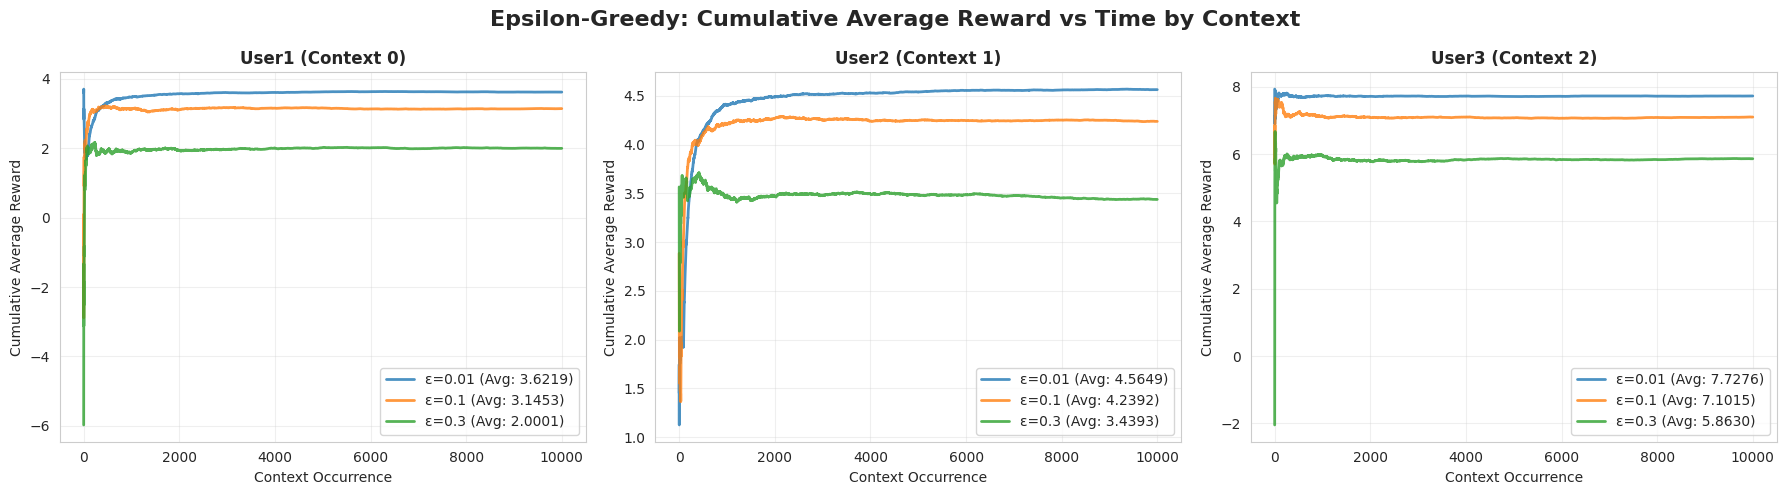

In [1124]:
# Plot Average Reward vs Time for each context - Epsilon-Greedy
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Epsilon-Greedy: Cumulative Average Reward vs Time by Context', fontsize=16, fontweight='bold')

contexts = ['User1 (Context 0)', 'User2 (Context 1)', 'User3 (Context 2)']

for ctx_idx in range(3):
    ax = axes[ctx_idx]
    
    for eps in EPSILON_VALUES:
        rewards = epsilon_greedy_results[eps]['context_rewards'][ctx_idx]
        
        if len(rewards) > 0:
            cumulative_avg = np.cumsum(rewards) / np.arange(1, len(rewards) + 1)
            
            ax.plot(range(len(cumulative_avg)), cumulative_avg,
                    label=f'ε={eps} (Avg: {np.mean(rewards):.4f})',
                    linewidth=2, alpha=0.8)
    
    ax.set_title(contexts[ctx_idx], fontsize=12, fontweight='bold')
    ax.set_xlabel('Context Occurrence', fontsize=10)
    ax.set_ylabel('Cumulative Average Reward', fontsize=10)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [1125]:
for eps in EPSILON_VALUES:
    for ctx in range(3):
        print(f"ε={eps}, Context {ctx} length:",
              len(epsilon_greedy_results[eps]['context_rewards'][ctx]))


ε=0.01, Context 0 length: 10000
ε=0.01, Context 1 length: 10000
ε=0.01, Context 2 length: 10000
ε=0.1, Context 0 length: 10000
ε=0.1, Context 1 length: 10000
ε=0.1, Context 2 length: 10000
ε=0.3, Context 0 length: 10000
ε=0.3, Context 1 length: 10000
ε=0.3, Context 2 length: 10000


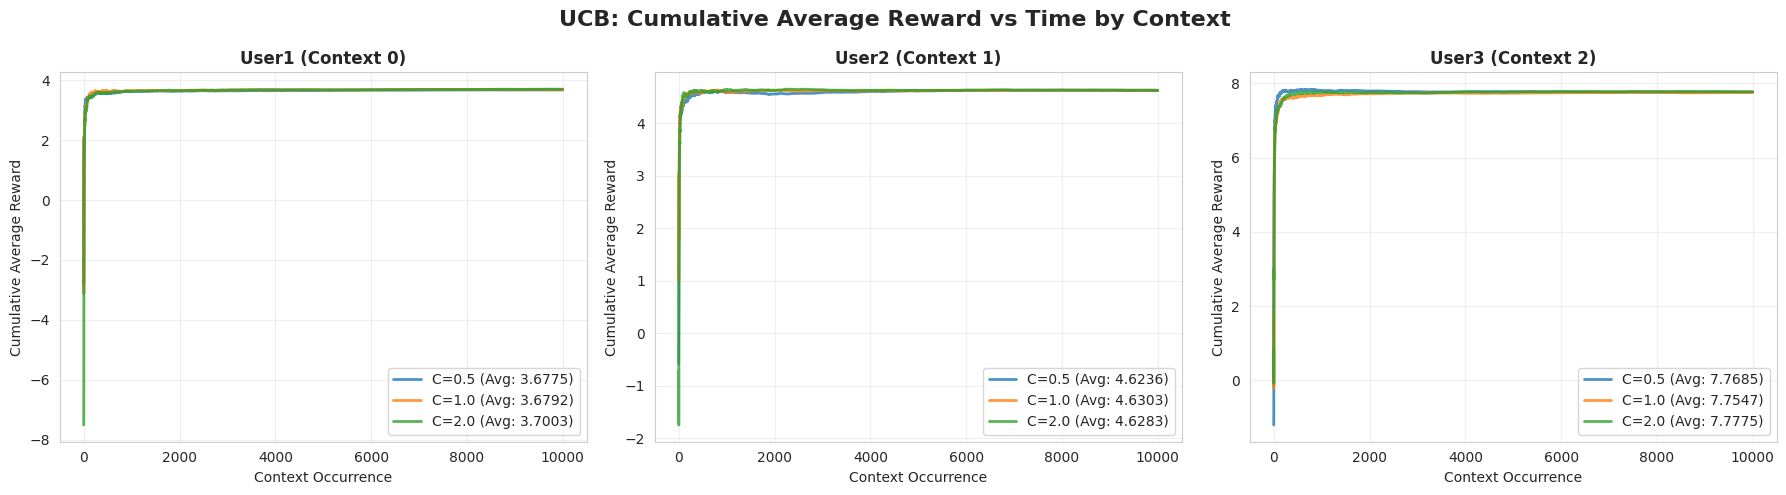

In [1126]:
# Plot Average Reward vs Time for each context - UCB
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('UCB: Cumulative Average Reward vs Time by Context', fontsize=16, fontweight='bold')

contexts = ['User1 (Context 0)', 'User2 (Context 1)', 'User3 (Context 2)']

for ctx_idx in range(3):
    ax = axes[ctx_idx]
    
    for c_val in C_VALUES:
        rewards = ucb_results[c_val]['context_rewards'][ctx_idx]
        
        if len(rewards) > 0:
            cumulative_avg = np.cumsum(rewards) / np.arange(1, len(rewards) + 1)
            
            ax.plot(range(len(cumulative_avg)), cumulative_avg,
                    label=f'C={c_val} (Avg: {np.mean(rewards):.4f})',
                    linewidth=2, alpha=0.8)
    
    ax.set_title(contexts[ctx_idx], fontsize=12, fontweight='bold')
    ax.set_xlabel('Context Occurrence', fontsize=10)
    ax.set_ylabel('Cumulative Average Reward', fontsize=10)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


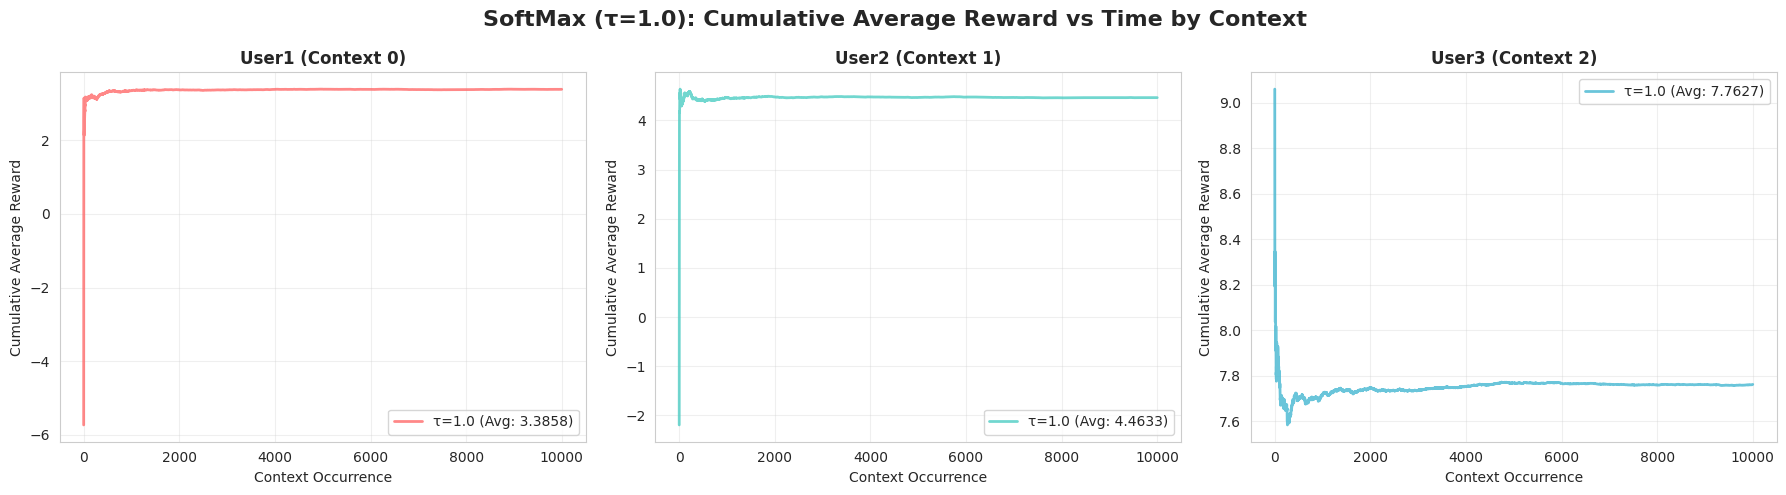

In [1127]:
# Plot Average Reward vs Time for each context - SoftMax
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f'SoftMax (τ={TAU}): Cumulative Average Reward vs Time by Context', fontsize=16, fontweight='bold')

for ctx_idx in range(3):
    ax = axes[ctx_idx]
    
    rewards = softmax_results['context_rewards'][ctx_idx]
    
    if len(rewards) > 0:
        cumulative_avg = np.cumsum(rewards) / np.arange(1, len(rewards) + 1)
        
        ax.plot(range(len(cumulative_avg)), cumulative_avg,
                color=colors[ctx_idx],
                label=f'τ={TAU} (Avg: {np.mean(rewards):.4f})',
                linewidth=2, alpha=0.8)
    
    ax.set_title(contexts[ctx_idx], fontsize=12, fontweight='bold')
    ax.set_xlabel('Context Occurrence', fontsize=10)
    ax.set_ylabel('Cumulative Average Reward', fontsize=10)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


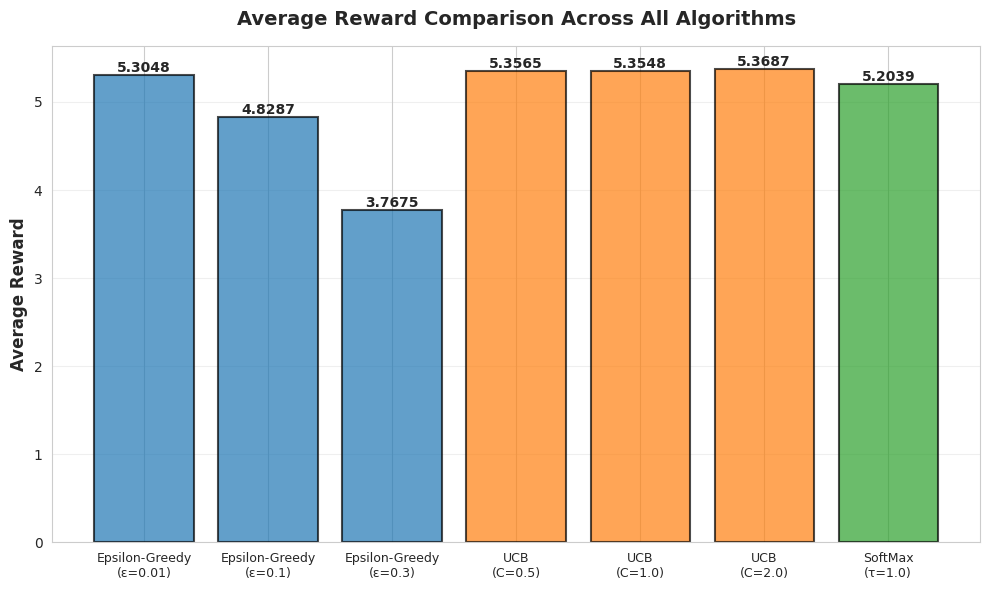

In [1128]:
# Bar chart comparing final average rewards
fig, ax = plt.subplots(figsize=(10, 6))

algorithms = ['Epsilon-Greedy\n(ε=0.01)', 'Epsilon-Greedy\n(ε=0.1)', 'Epsilon-Greedy\n(ε=0.3)',
              'UCB\n(C=0.5)', 'UCB\n(C=1.0)', 'UCB\n(C=2.0)', 
              'SoftMax\n(τ=1.0)']

avg_rewards = [
    np.mean(epsilon_greedy_results[0.01]['all_rewards']),
    np.mean(epsilon_greedy_results[0.1]['all_rewards']),
    np.mean(epsilon_greedy_results[0.3]['all_rewards']),
    np.mean(ucb_results[0.5]['all_rewards']),
    np.mean(ucb_results[1.0]['all_rewards']),
    np.mean(ucb_results[2.0]['all_rewards']),
    np.mean(softmax_results['all_rewards'])
]

colors_bar = ['#1f77b4']*3 + ['#ff7f0e']*3 + ['#2ca02c']
bars = ax.bar(algorithms, avg_rewards, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, value in zip(bars, avg_rewards):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('Average Reward', fontsize=12, fontweight='bold')
ax.set_title('Average Reward Comparison Across All Algorithms', 
             fontsize=14, fontweight='bold', pad=15)
ax.grid(True, axis='y', alpha=0.3)
plt.xticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

## Task 5.4: Recommendation Engine

In [1129]:
# Load news articles dataset
news_df = pd.read_csv('/kaggle/input/datasets/harkiratsingh2424/newsdata/news_articles.csv')  # Update path as needed
print(f"News Articles Dataset Shape: {news_df.shape}")
print(f"\nColumns: {list(news_df.columns)}")
print(f"\nCategory Distribution:")
print(news_df['category'].value_counts())
news_df.head()

News Articles Dataset Shape: (209527, 6)

Columns: ['link', 'headline', 'category', 'short_description', 'authors', 'date']

Category Distribution:
category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOO

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [1130]:
# Load test users dataset
test_users_df = pd.read_csv('/kaggle/input/datasets/harkiratsingh2424/testdata/test_users.csv')  # Update path as needed
print(f"Test Users Dataset Shape: {test_users_df.shape}")
test_users_df.head()

Test Users Dataset Shape: (2000, 32)


,user_id,age,income,clicks,purchase_amount,session_duration,content_variety,engagement_score,num_transactions,avg_monthly_spend,avg_cart_value,browsing_depth,revisit_rate,scroll_activity,time_on_site,interaction_count,preferred_price_range,discount_usage_rate,wishlist_size,product_views,repeat_purchase_gap (days),churn_risk_score,loyalty_index,screen_brightness,battery_percentage,cart_abandonment_count,browser_version,background_app_count,session_inactivity_duration,network_jitter,region_code,subscriber
0,U4058,36.0,10000,4,500.00,2.54,0.47162,49.32668,8,229.80,73.26,1,0.195,16,0.0,12,456.69,0.162,1,19,104.0,0.514808,13.0,3.0,39.0,3,5.99.65,7,7.86,26.0,X789,True
1,U1118,33.0,19607,8,1906.81,39.74,0.55219,56.42526,4,819.43,520.44,26,0.446,104,23.0,0,2011.72,0.393,5,44,92.0,0.514304,30.0,4.6,84.0,5,7.22.85,12,2.79,42.0,P752,True
2,U6555,51.0,21049,11,500.00,46.07,0.69961,58.88307,5,113.35,49.14,28,0.385,119,56.0,18,481.20,0.296,6,64,90.0,0.364154,21.0,2.1,88.0,7,3.29.28,11,27.50,11.0,P878,False
3,U9170,58.0,25752,13,500.00,60.86,0.86843,86.15690,8,237.13,31.75,38,0.656,161,48.0,26,497.81,0.358,3,67,46.0,0.065866,37.0,1.9,34.0,7,6.80.77,15,22.21,34.0,Z670,False
4,U3348,32.0,25302,12,2693.22,39.77,0.81805,84.82418,5,1491.56,572.96,25,0.567,127,25.0,15,2838.68,0.609,2,53,50.0,0.117989,45.0,3.0,6.0,6,9.29.14,8,11.44,0.0,M101,False


In [1131]:
# Make a copy
test_users_processed = test_users_df.copy()

# Store user_ids separately
if 'user_id' in test_users_processed.columns:
    user_ids = test_users_processed['user_id'].values
    test_users_processed = test_users_processed.drop('user_id', axis=1)
else:
    user_ids = np.arange(len(test_users_processed))

# Convert problematic object columns
for col in ['browser_version', 'region_code']:
    if col in test_users_processed.columns:
        test_users_processed[col] = pd.to_numeric(test_users_processed[col], errors='coerce')

# Impute missing numerical values
if num_cols_to_impute:
    test_users_processed[num_cols_to_impute] = numerical_imputer.transform(
        test_users_processed[num_cols_to_impute]
    )

# Encode categorical features
for col in cat_cols_to_encode:
    if col in test_users_processed.columns:
        test_users_processed[col] = test_users_processed[col].astype(str)

        mask = ~test_users_processed[col].isin(label_encoders[col].classes_)
        if mask.any():
            test_users_processed.loc[mask, col] = label_encoders[col].classes_[0]

        test_users_processed[col] = label_encoders[col].transform(test_users_processed[col])

# 🔥 VERY IMPORTANT: Match training column order
test_users_processed = test_users_processed[X_train.columns]

# 🔥 FINAL STEP: SCALE
test_users_scaled = scaler.transform(test_users_processed)


In [1132]:
class CMABRecommendationEngine:
    """
    Contextual Multi-Armed Bandit Recommendation Engine
    
    Combines user classification and bandit policies to recommend news articles.
    """
    
    def __init__(self, classifier, scaler, target_encoder, bandit_agent, news_df):
        """
        Args:
            classifier: Trained user classification model
            scaler: Fitted StandardScaler for feature scaling
            target_encoder: LabelEncoder for user categories
            bandit_agent: Trained bandit agent (EpsilonGreedy, UCB, or SoftMax)
            news_df: DataFrame containing news articles
        """
        self.classifier = classifier
        self.scaler = scaler
        self.target_encoder = target_encoder
        self.bandit_agent = bandit_agent
        self.news_df = news_df
        
        # Category mapping
        self.category_map = {
            0: 'ENTERTAINMENT',
            1: 'EDUCATION', 
            2: 'TECH',
            3: 'CRIME'
        }
        
    def classify_user(self, user_features):

        user_features_df = pd.DataFrame(
            [user_features],
            columns=self.scaler.feature_names_in_
        )
    
        user_features_scaled = self.scaler.transform(user_features_df)
    
        probs = self.classifier.predict_proba(user_features_scaled)[0]
        user_category_encoded = np.random.choice(len(probs), p=probs)
    
        user_category = self.target_encoder.inverse_transform([user_category_encoded])[0]
    
        context = user_category_encoded
    
        return context, user_category
    

    
    def select_news_category(self, context):
        # Use bandit agent policy instead of greedy-only
        arm = self.bandit_agent.select_arm(context)
        news_category = self.category_map[arm]
        return arm, news_category

    
    def sample_article(self, news_category):
        """
        Step 3: Randomly sample an article from the selected category
        """
        # Filter articles by category
        category_articles = self.news_df[self.news_df['category'] == news_category]
        
        if len(category_articles) == 0:
            return None
        
        # Randomly sample one article
        article = category_articles.sample(n=1).iloc[0]
        
        return article
    
    def recommend(self, user_features, return_details=True):
        """
        End-to-end recommendation pipeline
        
        Args:
            user_features: numpy array of user features
            return_details: if True, return detailed information
            
        Returns:
            Dictionary containing recommendation details
        """
        # Step 1: Classify user
        context, user_category = self.classify_user(user_features)
        
        # Step 2: Select news category using bandit
        arm, news_category = self.select_news_category(context)
        
        # Step 3: Sample article from category
        article = self.sample_article(news_category)
        
        if return_details:
            return {
                'user_category': user_category,
                'context': context,
                'news_category': news_category,
                'arm': arm,
                'article': article,
                'expected_reward': self.bandit_agent.Q[context, arm]
            }
        else:
            return news_category, article

In [1133]:
# Initialize recommendation engines with different bandit strategies
engines = {}

# Epsilon-Greedy Engine (with best epsilon)
engines['Epsilon-Greedy'] = CMABRecommendationEngine(
    classifier=best_model,
    scaler=scaler,
    target_encoder=target_encoder,
    bandit_agent=epsilon_greedy_agents[best_eps],
    news_df=news_df
)

# UCB Engine (with best C)
engines['UCB'] = CMABRecommendationEngine(
    classifier=best_model,
    scaler=scaler,
    target_encoder=target_encoder,
    bandit_agent=ucb_agents[best_c],
    news_df=news_df
)

# SoftMax Engine
engines['SoftMax'] = CMABRecommendationEngine(
    classifier=best_model,
    scaler=scaler,
    target_encoder=target_encoder,
    bandit_agent=softmax_agent,
    news_df=news_df
)

print("Recommendation engines initialized:")
for name in engines.keys():
    print(f"  - {name}")

Recommendation engines initialized:
  - Epsilon-Greedy
  - UCB
  - SoftMax


In [1134]:
# Select random test users
n_demo_users = 10
demo_indices = np.random.choice(len(test_users_processed), n_demo_users, replace=False)

for idx in demo_indices:
    user_features = test_users_processed.iloc[idx].values
    user_id = user_ids[idx]
    
    print(f"\n{'='*80}")
    print(f"USER ID: {user_id}")
    
    # Get recommendations from best performing engine
    engine_name = 'UCB'  # or choose based on best performance
    recommendation = engines[engine_name].recommend(user_features)
    
    print(f"\nClassified as: {recommendation['user_category']} (Context {recommendation['context']})")
    print(f"Recommended Category: {recommendation['news_category']}")
    print(f"Expected Reward: {recommendation['expected_reward']:.4f}")
    
    if recommendation['article'] is not None:
        print(f"\nRecommended Article:")
        print(f"  Headline: {recommendation['article']['headline']}")
        print(f"  Category: {recommendation['article']['category']}")
        if 'short_description' in recommendation['article']:
            desc = recommendation['article']['short_description']
            print(f"  Description: {desc[:200]}..." if len(str(desc)) > 200 else f"  Description: {desc}")
    else:
        print("  No articles available in this category")


USER ID: U4019

Classified as: user_2 (Context 1)
Recommended Category: EDUCATION
Expected Reward: 4.6315

Recommended Article:
  Headline: Betsy DeVos And Her 2015-16 School Choice Yearbook
  Category: EDUCATION
  Description: On November 23, 2016, President-elect Donald Trump nominated Betsy DeVos for U.S. Secretary of Education. DeVos is zealous

USER ID: U9466

Classified as: user_3 (Context 2)
Recommended Category: ENTERTAINMENT
Expected Reward: 7.7801

Recommended Article:
  Headline: Kanye Plays New Song During Awesome 'SNL 40' Performance
  Category: ENTERTAINMENT
  Description: nan

USER ID: U8766

Classified as: user_1 (Context 0)
Recommended Category: TECH
Expected Reward: 3.7043

Recommended Article:
  Headline: Watch The Top 9 YouTube Videos Of The Week
  Category: TECH
  Description: If you're looking to see the most popular YouTube videos of the week, look no further. Once again, we're bringing you the

USER ID: U0405

Classified as: user_2 (Context 1)
Recommended Categ

In [1135]:
# Generate recommendations for all test users
print("Generating recommendations for all test users...\n")

recommendations_df_list = []

for idx in range(len(test_users_processed)):
    user_features = test_users_processed.iloc[idx].values
    user_id = user_ids[idx]
    
    # Use best performing engine (UCB in this case)
    recommendation = engines['UCB'].recommend(user_features)
    
    rec_dict = {
        'user_id': user_id,
        'user_category': recommendation['user_category'],
        'recommended_category': recommendation['news_category'],
        'expected_reward': recommendation['expected_reward']
    }
    
    if recommendation['article'] is not None:
        rec_dict['article_headline'] = recommendation['article']['headline']
        if 'url' in recommendation['article']:
            rec_dict['article_url'] = recommendation['article']['url']
    
    recommendations_df_list.append(rec_dict)

# Create recommendations dataframe
recommendations_df = pd.DataFrame(recommendations_df_list)

print(f"Generated {len(recommendations_df)} recommendations")
print(f"\nRecommendation Distribution by Category:")
print(recommendations_df['recommended_category'].value_counts())
print(f"\nRecommendation Distribution by User Type:")
print(recommendations_df['user_category'].value_counts())

recommendations_df.head(10)

Generating recommendations for all test users...

Generated 2000 recommendations

Recommendation Distribution by Category:
recommended_category
EDUCATION        1365
TECH              390
ENTERTAINMENT     245
Name: count, dtype: int64

Recommendation Distribution by User Type:
user_category
user_2    1365
user_1     390
user_3     245
Name: count, dtype: int64


,user_id,user_category,recommended_category,expected_reward,article_headline
0,U4058,user_2,EDUCATION,4.631476,Do Grades Really Reflect Rigor?
1,U1118,user_3,ENTERTAINMENT,7.780104,13 Times Taylor Swift Showed Her Way With Word...
2,U6555,user_1,TECH,3.704255,Tim Cook Says EU Ruling On Apple's Irish Tax I...
3,U9170,user_2,EDUCATION,4.631476,How Paul Tough's Helping Children Succeed Help...
4,U3348,user_2,EDUCATION,4.631476,The Simple Way A Growing Number Of States Are ...
5,U2244,user_2,EDUCATION,4.631476,Living Your Future Is An Authentic Process
6,U3022,user_2,EDUCATION,4.631476,No Excuse Teaching
7,U5291,user_2,EDUCATION,4.631476,The Power of 'Yes'
8,U1945,user_2,EDUCATION,4.631476,Why I Decided Not To Do A PhD
9,U6084,user_3,ENTERTAINMENT,7.780104,"Dean Jones, Star Of Classic Disney Films, Dead..."


In [1136]:
# Save recommendations to CSV
recommendations_df.to_csv('recommendations_output.csv', index=False)
print("Recommendations saved to 'recommendations_output.csv'")

Recommendations saved to 'recommendations_output.csv'


## Task 5.5: Evaluation & Reporting

### 1. Classification Accuracy (Already shown in Task 5.2)

### 2. RL Simulation Results (T = 10,000 steps)

In [1137]:
# Summary table of all algorithm performances
summary_data = []

# Epsilon-Greedy results
for eps in EPSILON_VALUES:
    summary_data.append({
        'Algorithm': 'Epsilon-Greedy',
        'Hyperparameter': f'ε={eps}',
        'Average Reward': np.mean(epsilon_greedy_results[eps]['all_rewards']),
        'Std Dev': np.std(epsilon_greedy_results[eps]['all_rewards']),
        'Final Cumulative Avg': epsilon_greedy_results[eps]['cumulative_avg'][-1]
    })

# UCB results
for c_val in C_VALUES:
    summary_data.append({
        'Algorithm': 'UCB',
        'Hyperparameter': f'C={c_val}',
        'Average Reward': np.mean(ucb_results[c_val]['all_rewards']),
        'Std Dev': np.std(ucb_results[c_val]['all_rewards']),
        'Final Cumulative Avg': ucb_results[c_val]['cumulative_avg'][-1]
    })

# SoftMax results
summary_data.append({
    'Algorithm': 'SoftMax',
    'Hyperparameter': f'τ={TAU}',
    'Average Reward': np.mean(softmax_results['all_rewards']),
    'Std Dev': np.std(softmax_results['all_rewards']),
    'Final Cumulative Avg': softmax_results['cumulative_avg'][-1]
})

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Average Reward', ascending=False)

print("\nRL SIMULATION SUMMARY (T=10,000)")
print(summary_df.to_string(index=False))


RL SIMULATION SUMMARY (T=10,000)
     Algorithm Hyperparameter  Average Reward  Std Dev  Final Cumulative Avg
           UCB          C=2.0        5.368713 2.071799              5.368713
           UCB          C=0.5        5.356514 2.077207              5.356514
           UCB          C=1.0        5.354766 2.069048              5.354766
Epsilon-Greedy         ε=0.01        5.304794 2.176166              5.304794
       SoftMax          τ=1.0        5.203930 2.240053              5.203930
Epsilon-Greedy          ε=0.1        4.828671 2.853019              4.828671
Epsilon-Greedy          ε=0.3        3.767465 3.786094              3.767465


### 3. Analysis Plots (Already shown in Task 5.3)